In [1]:
!nvidia-smi

Thu Jul 28 15:11:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   57C    P0   250W / 300W |  21027MiB / 32505MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
import sys
import json
import time
import rich
import numpy as np
import pickle
import wandb
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from configs.finetune import FinetuneConfig
from tasks.classification import Classification

from models.backbone.base import calculate_out_features
from models.backbone.densenet import DenseNetBackbone
from models.backbone.resnet import build_resnet_backbone
from models.head.projector import MLPHead
from models.head.classifier import LinearClassifier

from datasets.brain import BrainProcessor, Brain, BrainMoCo
from datasets.transforms import make_transforms, compute_statistics

from utils.logging import get_rich_logger
from utils.gpu import set_gpu

from easydict import EasyDict as edict
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
from matplotlib import colors

from skimage.transform import resize

In [1]:
# TODO: change pet-moco / config directories

In [6]:
gpus = ['3']
server = 'dgx'

hashs =[("2022-07-02_08-00-31", "2022-07-03_13-41-32"),
        ("2022-07-02_08-00-57", "2022-07-03_13-37-29"),
        ("2022-07-02_09-38-52", "2022-07-03_13-33-23"),
        ("2022-07-02_09-40-42", "2022-07-03_13-29-10"),
        ("2022-07-02_11-17-38", "2022-07-03_13-25-05"),
        ("2022-07-02_11-20-21", "2022-07-03_13-21-00"),
        ("2022-07-02_17-15-14", "2022-07-03_13-16-54"),
        ("2022-07-02_17-15-34", "2022-07-03_13-12-44"),
        ("2022-07-02_18-53-46", "2022-07-03_13-08-35"),
        ("2022-07-02_18-54-27", "2022-07-03_13-04-32")]
hash = hashs[0]

In [7]:
config = edict()
config.server = server
config.gpus = gpus
local_rank = 0

config.finetune_file = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/ckpt.last.pth.tar')
finetune_config = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/configs.json')
with open(finetune_config, 'rb') as fb:
    finetune_config = json.load(fb)

finetune_config_names = [
    # data_parser
    'data_type', 'root', 'data_info', 'mci_only', 'n_splits', 'n_cv',
    'image_size', 'small_kernel', 'random_state',
    'intensity', 'crop', 'crop_size', 'rotate', 'flip', 'affine', 'blur', 'blur_std', 'prob',
    # model_parser
    'backbone_type', 'init_features', 'growth_rate', 'block_config', 'bn_size', 'dropout_rate',
    'arch', 'no_max_pool',
    # train
    'batch_size',
    # moco / supmoco
    'alphas',
    # others
    'task', 'projector_dim'
]

for name in finetune_config_names:
    if name in finetune_config.keys():
        setattr(config, name, finetune_config[name])

In [8]:
print(config.random_state)

2021


In [9]:
set_gpu(config)
np.random.seed(config.random_state)
torch.manual_seed(config.random_state)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
torch.cuda.set_device(local_rank)

# Networks
if config.backbone_type == 'densenet':
    backbone = DenseNetBackbone(in_channels=1,
                                init_features=config.init_features,
                                growth_rate=config.growth_rate,
                                block_config=config.block_config,
                                bn_size=config.bn_size,
                                dropout_rate=config.dropout_rate,
                                semi=False)
    activation = True
elif config.backbone_type == 'resnet':
    backbone = build_resnet_backbone(arch=config.arch,
                                     no_max_pool=config.no_max_pool,
                                     in_channels=1,
                                     semi=False)
    activation = False
else:
    raise NotImplementedError

if config.small_kernel:
    backbone._fix_first_conv()

if config.crop:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.crop_size)
else:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.image_size)
projector = MLPHead(out_dim, config.projector_dim)

backbone.load_weights_from_checkpoint(path=config.finetune_file, key='backbone')
projector.load_weights_from_checkpoint(path=config.finetune_file, key='head')

# load finetune data
data_processor = BrainProcessor(root=config.root,
                                data_info=config.data_info,
                                data_type=config.data_type,
                                mci_only=config.mci_only,
                                random_state=config.random_state)
datasets = data_processor.process(n_splits=config.n_splits, n_cv=config.n_cv)

# intensity normalization
assert config.intensity in [None, 'scale', 'minmax']
mean_std, min_max = (None, None), (None, None)
if config.intensity is None:
    pass
elif config.intensity == 'scale':
    pass
elif config.intensity == 'minmax':
    with open(os.path.join(config.root, 'labels/minmax.pkl'), 'rb') as fb:
        minmax_stats = pickle.load(fb)
        min_max = (minmax_stats[config.data_type]['min'], minmax_stats[config.data_type]['max'])
else:
    raise NotImplementedError

train_transform, test_transform = make_transforms(image_size=config.image_size,
                                                  intensity=config.intensity,
                                                  mean_std=mean_std,
                                                  min_max=min_max,
                                                  crop=config.crop,
                                                  crop_size=config.crop_size,
                                                  rotate=config.rotate,
                                                  flip=config.flip,
                                                  affine=config.affine,
                                                  blur=config.blur,
                                                  blur_std=config.blur_std,
                                                  prob=config.prob)

train_set = Brain(dataset=datasets['train'], data_type=config.data_type, transform=test_transform)
test_set = Brain(dataset=datasets['test'], data_type=config.data_type, transform=test_transform)

train_loader = DataLoader(dataset=train_set, batch_size=16, drop_last=False)
test_loader = DataLoader(dataset=test_set, batch_size=16, drop_last=False)

In [10]:
total_set = {'mri': datasets['train']['mri'] + datasets['u_train']['mri'],
             'pet': datasets['train']['pet'] + datasets['u_train']['pet'],
             'y': np.concatenate([datasets['train']['y'], datasets['u_train']['y']])}
total_set = Brain(dataset=total_set, data_type=config.data_type, transform=test_transform)
total_loader = DataLoader(dataset=total_set, batch_size=16, drop_last=False)

In [13]:
@torch.no_grad()
def extract_features(data_loader, encoder: nn.Module, projector: nn.Module, device: int):
    
    encoder.to(device)
    encoder.eval()
    
    Z = []
    y = []
    for i, batch in enumerate(tqdm.tqdm(data_loader)):
        x = batch['x'].to(device)
        z = encoder(x)        
        Z += [z]
        y += [batch['y'].to(device)]
        
    encoder.to('cpu')
    
    Z = torch.cat(Z, dim=0)
    y = torch.cat(y, dim=0)
    
    return Z, y

In [14]:
Z, Y = extract_features(total_loader, backbone, projector, 0)
Z = nn.AdaptiveAvgPool3d(1)(Z)
Z = np.squeeze(Z)
print(Z.shape)

100%|██████████| 62/62 [00:52<00:00,  1.17it/s]

torch.Size([984, 2048])


In [16]:
Z = Z.detach().cpu().numpy()
Y = Y.detach().cpu().numpy()

# 1. UMAP

In [17]:
import umap.umap_ as umap

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


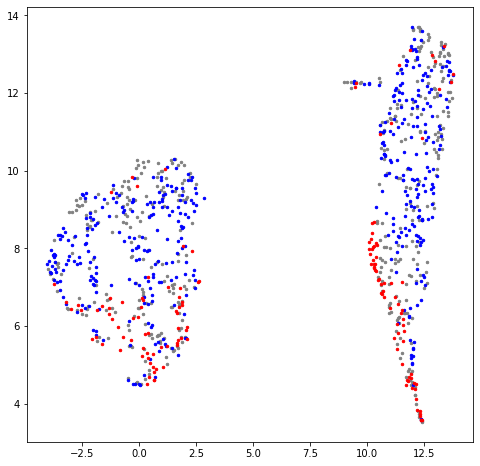

In [18]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.2)
embedding = reducer.fit_transform(Z)
classes = [-1, 0, 1]
colors = ['grey', 'blue', 'red']
plt.figure(figsize=(8, 8))
for c, color in zip(classes, colors):
    plt.scatter(embedding[Y==c, 0], embedding[Y==c, 1], s=6, color=colors[c+1])
plt.show()

# load amyloid info

In [18]:
import pandas as pd
amyloid_info = pd.read_excel('/raidWorkspace/mingu/Data/ADNI/labels/AV45_FBP_SUVR.xlsx', sheet_name='list_id_SUVR_RSF', engine='openpyxl')
amyloid_info = amyloid_info[['ID', 'AmyloidPositive_CL20', 'AmyloidPositive_CL37']]

In [43]:
left_idx = np.where(embedding[:, 0] < 6.0)[0]
right_idx = np.where(embedding[:, 0] > 6.0)[0]
len(left_idx) + len(right_idx) == len(total_set)

True

In [71]:
left_id = np.array(total_set.pet)[left_idx]
left_id = [i.split('/')[-1].replace('.pkl', '') for i in left_id]
left_y = np.array(total_set.y)[left_idx]

right_id = np.array(total_set.pet)[right_idx]
right_id = [i.split('/')[-1].replace('.pkl', '') for i in right_id]
right_y = np.array(total_set.y)[right_idx]

In [74]:
left_cl20 = [amyloid_info.loc[amyloid_info.ID == a, 'AmyloidPositive_CL20'].item() for a in left_id]
left_cl37 = [amyloid_info.loc[amyloid_info.ID == a, 'AmyloidPositive_CL37'].item() for a in left_id]

right_cl20 = [amyloid_info.loc[amyloid_info.ID == a, 'AmyloidPositive_CL20'].item() for a in right_id]
right_cl37 = [amyloid_info.loc[amyloid_info.ID == a, 'AmyloidPositive_CL37'].item() for a in right_id]

In [82]:
left_df = pd.DataFrame({'label': left_y, 'cl20': left_cl20, 'cl37': left_cl37})
right_df = pd.DataFrame({'label': right_y, 'cl20': right_cl20, 'cl37': right_cl37})

In [77]:
pd.pivot_table(left_df, values='cl20', index='label', columns=['cl20'], aggfunc='count')

cl20,0,1
label,,
-1,93,111
0,124,93
1,3,64


In [83]:
pd.pivot_table(right_df, values='cl20', index='label', columns=['cl20'], aggfunc='count')

cl20,0,1
label,,
-1,123,92
0,143,62
1,12,64


In [85]:
pd.pivot_table(left_df, values='cl37', index='label', columns=['cl37'], aggfunc='count')

cl37,0,1
label,,
-1,111,93
0,149,68
1,7,60


In [86]:
pd.pivot_table(right_df, values='cl37', index='label', columns=['cl37'], aggfunc='count')

cl37,0,1
label,,
-1,140,75
0,160,45
1,14,62


# Demo

In [88]:
demo_info = pd.read_excel('/raidWorkspace/mingu/Data/ADNI/labels/AV45_FBP_SUVR.xlsx', sheet_name='demographic info', engine='openpyxl')
demo_info = demo_info[['ID1', 'RID', 'Age', 'VISCODE2']]

In [95]:
left_rid = [demo_info.loc[demo_info.ID1 == a, 'RID'].item() for a in left_id]
left_age = [demo_info.loc[demo_info.ID1 == a, 'Age'].item() for a in left_id]
left_vc = [demo_info.loc[demo_info.ID1 == a, 'VISCODE2'].item() for a in left_id]

right_rid = [demo_info.loc[demo_info.ID1 == a, 'RID'].item() for a in right_id]
right_age = [demo_info.loc[demo_info.ID1 == a, 'Age'].item() for a in right_id]
right_vc = [demo_info.loc[demo_info.ID1 == a, 'VISCODE2'].item() for a in right_id]

In [104]:
left_df = pd.DataFrame({'label': left_y, 'age': left_age, 'vc': left_vc})
right_df = pd.DataFrame({'label': right_y, 'age': right_age, 'vc': right_vc})

In [105]:
pd.pivot_table(left_df, values='age', index='label', aggfunc=np.mean)

,age
label,
-1,74.485576
0,70.818484
1,74.493110


In [106]:
pd.pivot_table(right_df, values='age', index='label', aggfunc=np.mean)

,age
label,
-1,77.253953
0,74.520107
1,76.465213


In [150]:
left_df['cluster'] = 'Cluster A'
right_df['cluster'] = 'Cluster B'

In [151]:
df = pd.concat([left_df, right_df]).reset_index(drop=True)
df = df.loc[df.label != -1].reset_index(drop=True)

In [152]:
df

,label,age,vc,cluster
0,0,78.284932,m60,Cluster A
1,1,80.257534,m84,Cluster A
2,0,75.778082,m60,Cluster A
3,1,86.364384,m84,Cluster A
4,0,79.665753,m60,Cluster A
...,...,...,...,...
560,1,70.772603,bl,Cluster B
561,0,69.693151,m24,Cluster B
562,0,71.786301,m24,Cluster B
563,1,71.443836,bl,Cluster B


In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

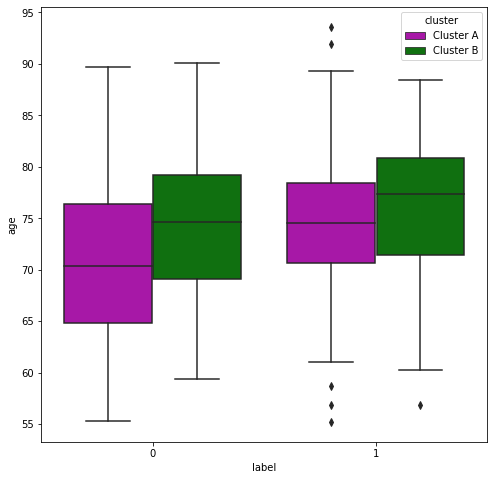

In [154]:
plt.figure(figsize=(8, 8))
sns.boxplot(x="label", y="age", palette=["m", "g"], hue='cluster',
            data=df)
plt.show()

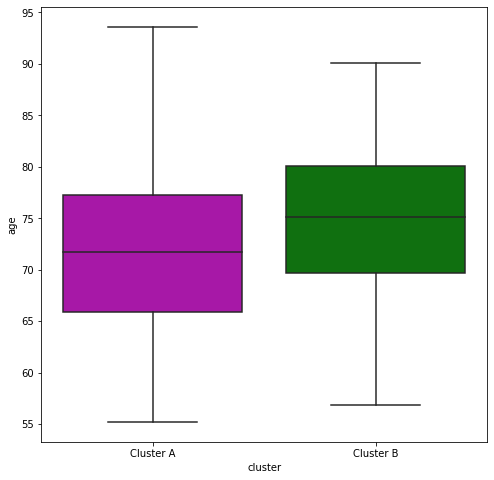

In [156]:
plt.figure(figsize=(8, 8))
sns.boxplot(x="cluster", y="age", palette=["m", "g"],
            data=df)
plt.show()

In [163]:
from scipy import stats

In [169]:
for label in [0, 1]:
    a = temp.loc[temp.cluster == 'Cluster A']['age'].values
    b = temp.loc[temp.cluster == 'Cluster B']['age'].values
    
    tstat, pval = stats.ttest_ind(a, b, alternative='less', equal_var=False)
    print(pval)

3.0373643075944314e-07
3.0373643075944314e-07


# 2. TSNE

In [34]:
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding

In [23]:
tsne = TSNE(n_components=2, perplexity=30.0, learning_rate=200.0, n_iter=2000, metric='euclidean', init='pca')

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


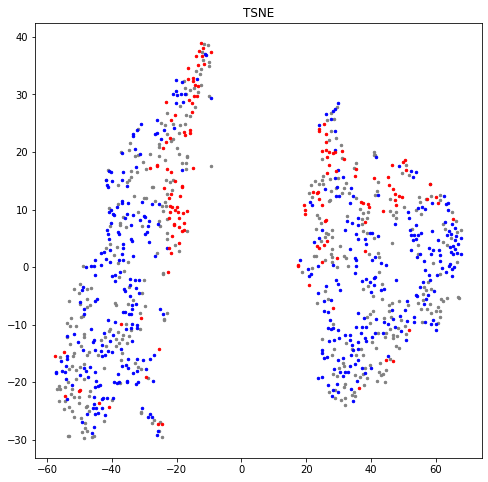

In [31]:
embedding = tsne.fit_transform(Z)
classes = [-1, 0, 1]
colors = ['grey', 'blue', 'red']
plt.figure(figsize=(8, 8))
for c, color in zip(classes, colors):
    plt.scatter(embedding[Y==c, 0], embedding[Y==c, 1], s=6, color=colors[c+1])
plt.title('TSNE')
plt.show()

In [32]:
isomap = Isomap(n_neighbors=10, n_components=2)

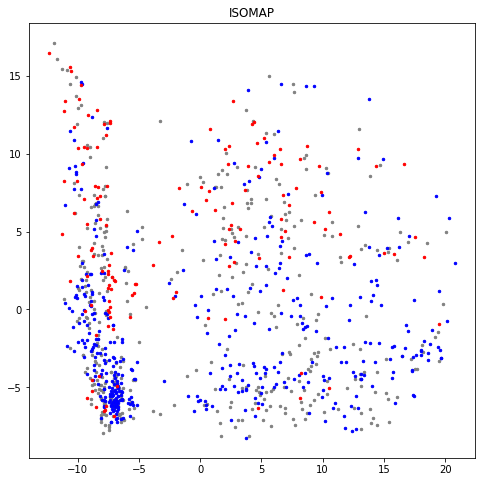

In [33]:
embedding = isomap.fit_transform(Z)
classes = [-1, 0, 1]
colors = ['grey', 'blue', 'red']
plt.figure(figsize=(8, 8))
for c, color in zip(classes, colors):
    plt.scatter(embedding[Y==c, 0], embedding[Y==c, 1], s=6, color=colors[c+1])
plt.title('ISOMAP')
plt.show()

In [37]:
lle = LocallyLinearEmbedding(n_neighbors=15, n_components=2)

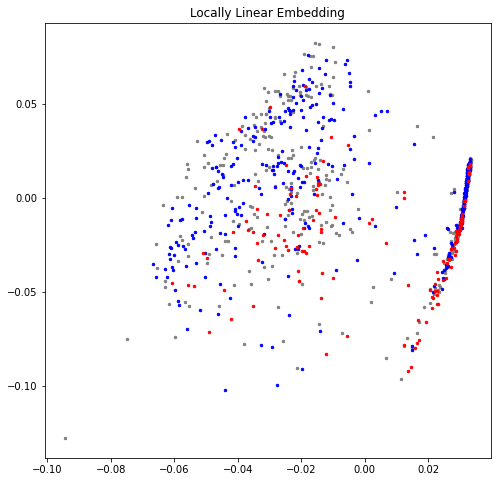

In [38]:
embedding = lle.fit_transform(Z)
classes = [-1, 0, 1]
colors = ['grey', 'blue', 'red']
plt.figure(figsize=(8, 8))
for c, color in zip(classes, colors):
    plt.scatter(embedding[Y==c, 0], embedding[Y==c, 1], s=6, color=colors[c+1])
plt.title('Locally Linear Embedding')
plt.show()